In [1]:
import yt
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataloc = "/home/kwoksun2/FLASH4.6/turb_data/energy=9/"
chk_files = glob.glob(dataloc + "*chk*")
chk_files = sorted(chk_files)
log_files = glob.glob(dataloc + "*.dat")

In [3]:
filename = dataloc + "Turb.dat"
def change_list_to_array(l):
    out = []
    for ele in l:
        try:
            out.append(float(ele))
        except:
            pass
    return np.array(out).astype(float)

logfile_data = []
i = 0
with open (filename) as f:
    for l in f.readlines():
        if i >0 and ("time" not in l):
            logfile_data.append(change_list_to_array(l.split(" ")))
        else:
            keys = [ a for a in l.split(' ') if a !='' ]
        i += 1

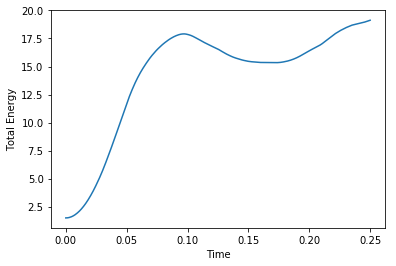

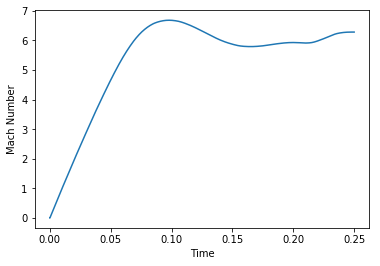

In [4]:
logfile_data = np.array(logfile_data)
time = []
Etot = []
Mach = []

for d in logfile_data:
    time.append( d[0] )
    Etot.append( d[5])
    Mach.append( d[8])
    

# time = all_data[:,0]
# Etot = all_data[:,5]
t = 0.25
time = np.array(time)
Etot = np.array(Etot)
Mach = np.array(Mach)
plt.plot(time[time < t], Etot[time < t])
plt.ylabel('Total Energy')
plt.xlabel('Time')
plt.show()

plt.plot(time[time < t], Mach[time < t])
plt.ylabel('Mach Number')
plt.xlabel('Time')

plt.show()


yt : [INFO     ] 2019-05-09 21:48:47,134 Particle file found: Turb_hdf5_chk_0013
yt : [INFO     ] 2019-05-09 21:48:47,165 Parameters: current_time              = 0.26000202635463054
yt : [INFO     ] 2019-05-09 21:48:47,166 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2019-05-09 21:48:47,167 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2019-05-09 21:48:47,168 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2019-05-09 21:48:47,169 Parameters: cosmological_simulation   = 0.0
/home/kwoksun2/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ret = super(YTArray, self).__getitem__(item)
/home/kwoksun2/anaconda3/lib/python3.7/site-pac


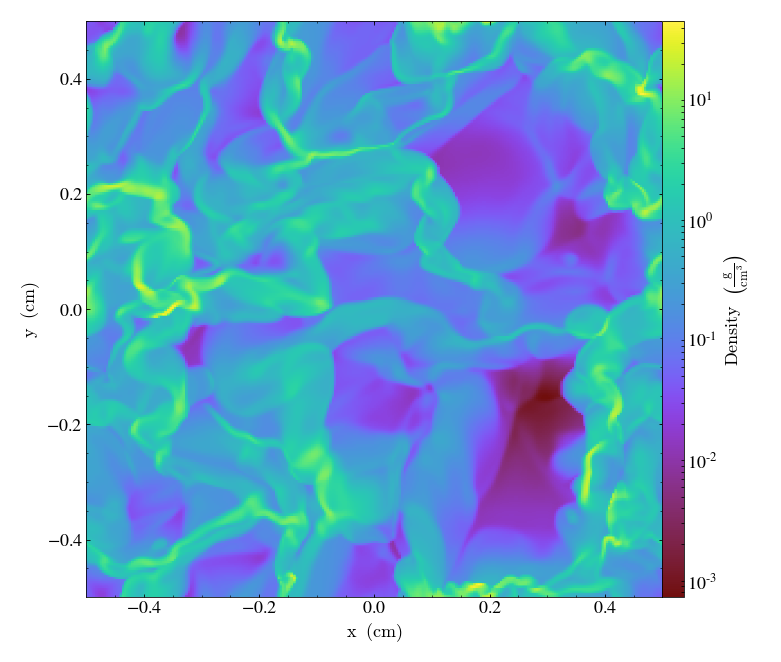

yt : [INFO     ] 2019-05-09 21:48:51,731 Projection completed
yt : [INFO     ] 2019-05-09 21:48:51,734 xlim = -0.500000 0.500000
yt : [INFO     ] 2019-05-09 21:48:51,735 ylim = -0.500000 0.500000
yt : [INFO     ] 2019-05-09 21:48:51,736 xlim = -0.500000 0.500000
yt : [INFO     ] 2019-05-09 21:48:51,737 ylim = -0.500000 0.500000
yt : [INFO     ] 2019-05-09 21:48:51,739 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



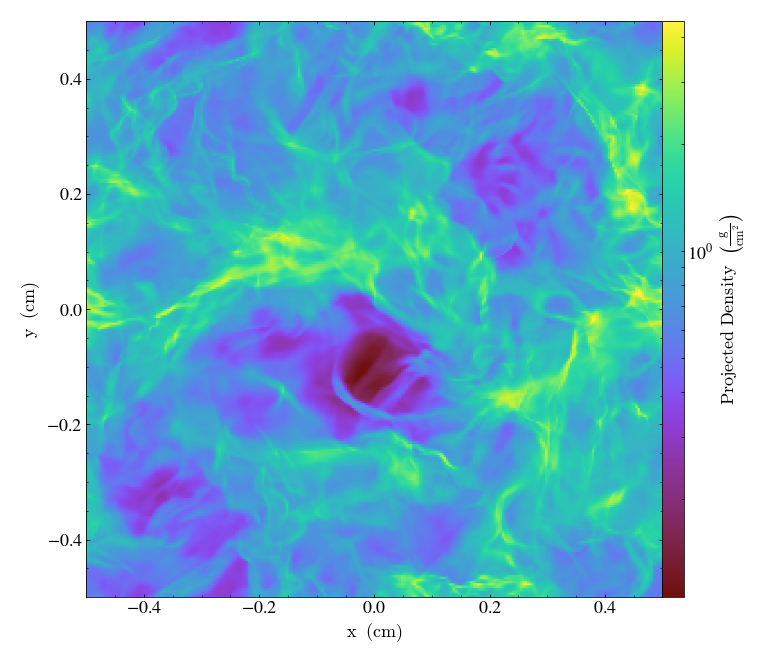

In [5]:
ds = yt.load(chk_files[-1])
slc = yt.SlicePlot(ds,"z","density")
slc.show()

proj = yt.ProjectionPlot(ds,"z","density")
proj.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import yt

"""
Make a turbulent KE power spectrum.  Since we are stratified, we use
a rho**(1/3) scaling to the velocity to get something that would
look Kolmogorov (if the turbulence were fully developed).

Ultimately, we aim to compute:

                      1  ^      ^*
     E(k) = integral  -  V(k) . V(k) dS
                      2

             n                                               ^
where V = rho  U is the density-weighted velocity field, and V is the
FFT of V.

(Note: sometimes we normalize by 1/volume to get a spectral
energy density spectrum).


"""


def doit(ds, nindex_rho = 1./3.):

    # a FFT operates on uniformly gridded data.  We'll use the yt
    # covering grid for this.

    max_level = ds.index.max_level

#     ref = int(np.product(ds.ref_factors[0:max_level]))
    ref = 1
    
    low = ds.domain_left_edge
    dims = ds.domain_dimensions*ref

    nx, ny, nz = dims

    Kk = np.zeros( (nx//2+1, ny//2+1, nz//2+1))

    for vel in [("gas", "velocity_x"), ("gas", "velocity_y"),
                ("gas", "velocity_z")]:

        Kk += 0.5*fft_comp(ds, ("gas", "density"), vel,
                           nindex_rho, max_level, low, dims)

    # wavenumbers
    L = (ds.domain_right_edge - ds.domain_left_edge).d

    kx = np.fft.rfftfreq(nx)*nx/L[0]
    ky = np.fft.rfftfreq(ny)*ny/L[1]
    kz = np.fft.rfftfreq(nz)*nz/L[2]

    # physical limits to the wavenumbers
    kmin = np.min(1.0/L)
    kmax = np.min(0.5*dims/L)

    kbins = np.arange(kmin, kmax, kmin)
    N = len(kbins)

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    whichbin = np.digitize(k.flat, kbins)
    ncount = np.bincount(whichbin)

    E_spectrum = np.zeros(len(ncount)-1)

    for n in range(1,len(ncount)):
        E_spectrum[n-1] = np.sum(Kk.flat[whichbin==n])

    k = 0.5*(kbins[0:N-1] + kbins[1:N])
    E_spectrum = E_spectrum[1:N]

    index = np.argmax(E_spectrum)
    kmax = k[index]
    Emax = E_spectrum[index]
    
    return k, E_spectrum, Emax*(k/kmax)**(-2.)
    
#     plt.loglog(k, E_spectrum)
#     plt.loglog(k, Emax*(k/kmax)**(-5./3.), ls=":", color="0.5")

#     plt.xlabel(r"$k$")
#     plt.ylabel(r"$E(k)dk$")

#     plt.savefig("spectrum.png")


def fft_comp(ds, irho, iu, nindex_rho, level, low, delta ):

    cube = ds.covering_grid(level, left_edge=low,
                            dims=delta,
                            fields=[irho, iu])

    rho = cube[irho].d
    u = cube[iu].d

    nx, ny, nz = rho.shape

    # do the FFTs -- note that since our data is real, there will be
    # too much information here.  fftn puts the positive freq terms in
    # the first half of the axes -- that's what we keep.  Our
    # normalization has an '8' to account for this clipping to one
    # octant.
    ru = np.fft.fftn(rho**nindex_rho * u)[0:nx//2+1,0:ny//2+1,0:nz//2+1]
    ru = 8.0*ru/(nx*ny*nz)

    return np.abs(ru)**2

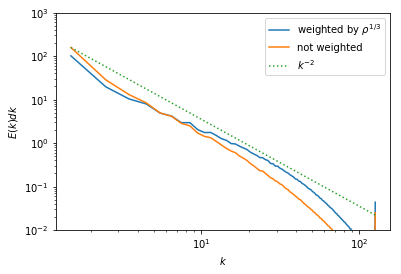

In [7]:
k, Ek, Ekol = doit(ds, nindex_rho = 1./3.)
k, Ek_rho0, Ekol = doit(ds, nindex_rho = 0.0)

plt.loglog(k, Ek, label=r'weighted by $\rho^{1/3}$')
plt.loglog(k, Ek_rho0, label='not weighted' )
    
plt.loglog(k, Ekol, ls=":", label = "$k^{-2}$")
plt.ylim(1.0e-2,1.0e3)
plt.xlabel(r"$k$")
plt.ylabel(r"$E(k)dk$")
plt.legend()
plt.show()

In [8]:
def doit(ds, nindex_rho = 1./3.):

    # a FFT operates on uniformly gridded data.  We'll use the yt
    # covering grid for this.

    max_level = ds.index.max_level

#     ref = int(np.product(ds.ref_factors[0:max_level]))
    ref = 1
    
    low = ds.domain_left_edge
    dims = ds.domain_dimensions*ref

    nx, ny, nz = dims

    Kk = np.zeros( (nx//2+1, ny//2+1, nz//2+1))

    for vel in [("gas", "velocity_x"), ("gas", "velocity_y"),
                ("gas", "velocity_z")]:

        Kk += 0.5*fft_comp(ds, ("gas", "density"), vel,
                           nindex_rho, max_level, low, dims)

    # wavenumbers
    L = (ds.domain_right_edge - ds.domain_left_edge).d

    kx = np.fft.rfftfreq(nx)*nx/L[0]
    ky = np.fft.rfftfreq(ny)*ny/L[1]
    kz = np.fft.rfftfreq(nz)*nz/L[2]

    # physical limits to the wavenumbers
    kmin = np.min(1.0/L)
    kmax = np.min(0.5*dims/L)

    kbins = np.arange(kmin, kmax, kmin)
    N = len(kbins)

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    whichbin = np.digitize(k.flat, kbins)
    ncount = np.bincount(whichbin)

    E_spectrum = np.zeros(len(ncount)-1)

    for n in range(1,len(ncount)):
        E_spectrum[n-1] = np.sum(Kk.flat[whichbin==n])

    k = 0.5*(kbins[0:N-1] + kbins[1:N])
    E_spectrum = E_spectrum[1:N]

    index = np.argmax(E_spectrum)
    kmax = k[index]
    Emax = E_spectrum[index]
    
    return k, E_spectrum, Emax*(k/kmax)**(-2.)

def fft_comp_smooth(ds, irho, iu, nindex_rho, level, low, delta, smooth_ncell ):

    cube = ds.covering_grid(level, left_edge=low,
                            dims=delta,
                            fields=[irho, iu])

    rho = cube[irho].d
    u = cube[iu].d

    nx, ny, nz = rho.shape

    # do the FFTs -- note that since our data is real, there will be
    # too much information here.  fftn puts the positive freq terms in
    # the first half of the axes -- that's what we keep.  Our
    # normalization has an '8' to account for this clipping to one
    # octant.
    ru = np.fft.fftn(rho**nindex_rho * u)[0:nx//2+1,0:ny//2+1,0:nz//2+1]
    ru = 8.0*ru/(nx*ny*nz)

    return np.abs(ru)**2

In [47]:
def smoothing_3d_cube( myfield, window = 2 ):
    
    nx,ny,nz = myfield.shape
    
    smooth_field = np.zeros( (nx//window,  ny//window,  nz//window) )
    for i in range(window):
        for j in range(window):
            for k in range(window):
                smooth_field += myfield[i::window,j::window,k::window]
    return smooth_field

def smoothing_velocity_field( myfield, window = 2, weight = 1.0 ):
    
    nx,ny,nz = myfield.shape
    
    smooth_dfield = np.zeros( (nx//window,  ny//window,  nz//window) )
    smooth_vfield = np.zeros( (nx//window,  ny//window,  nz//window) )
    if type(weight) == float:
        weight *= np.ones( (nx,ny,nz) )
    
    for i in range(window):
        for j in range(window):
            for k in range(window):
                smooth_dfield += weight[i::window,j::window,k::window]
                smooth_vfield += weight[i::window,j::window,k::window] * myfield[i::window,j::window,k::window]
                
    return smooth_vfield / smooth_dfield

In [48]:
from generate_3dIC import calculate_power_spectrum

max_level = ds.index.max_level
ref = 1
low = ds.domain_left_edge
dims = ds.domain_dimensions*ref

cube256 = ds.covering_grid(max_level, left_edge=low,
                            dims=dims,
                            fields=[("gas", "density"), 
                                   ("gas", "velocity_x"),
                                   ("gas", "velocity_y"),
                                   ("gas", "velocity_z")] )

rho256 = cube256[("gas", "density")].d
vx256  = cube256[("gas", "velocity_x")].d
vy256  = cube256[("gas", "velocity_y")].d
vz256  = cube256[("gas", "velocity_z")].d

d_vx64 = smoothing_velocity_field( vx256, window = 4, weight = rho256 )
d_vy64 = smoothing_velocity_field( vy256, window = 4, weight = rho256 )
d_vz64 = smoothing_velocity_field( vz256, window = 4, weight = rho256 )
rho64  = smoothing_velocity_field( rho256, window = 4, weight = 1.0 )

k, Pkx = calculate_power_spectrum(d_vx64, Rkbins = 64)
k, Pky = calculate_power_spectrum(d_vy64, Rkbins = 64)
k, Pkz = calculate_power_spectrum(d_vz64, Rkbins = 64)

# get around the artifical dissipation range in simulations

It is known that in grid code, the turbulent inertial range is limited, in this section, we demonstrates this, and find a way to get around it by smoothing the simulation.

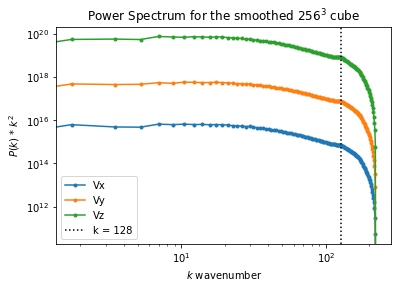

In [37]:
k, Pkx = calculate_power_spectrum(vx256, Rkbins = 128)
k, Pky = calculate_power_spectrum(vy256, Rkbins = 128)
k, Pkz = calculate_power_spectrum(vz256, Rkbins = 128)
Pkx = np.array(Pkx)
Pky = np.array(Pky)
Pkz = np.array(Pkz)

plt.loglog(k,Pkx * k*k, marker=".", label='Vx')
plt.loglog(k,Pky*1e2* k*k, marker=".", label='Vy')
plt.loglog(k,Pkz*1e4* k*k, marker=".", label='Vz')

plt.axvline(128,color='k',ls=':',label="k = 128")
plt.title('Power Spectrum for the smoothed $256^3$ cube')
plt.ylabel("$P(k)$ * $k^2$")
plt.xlabel("$k$ wavenumber")
plt.legend()

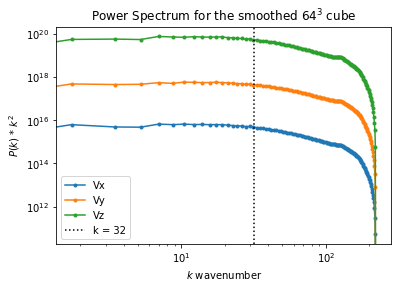

In [36]:
Pkx = np.array(Pkx)
Pky = np.array(Pky)
Pkz = np.array(Pkz)

plt.loglog(k,Pkx * k*k, marker=".", label='Vx')
plt.loglog(k,Pky*1e2* k*k, marker=".", label='Vy')
plt.loglog(k,Pkz*1e4* k*k, marker=".", label='Vz')
plt.axvline(32,color='k',ls=':',label="k = 32")
plt.title('Power Spectrum for the smoothed $64^3$ cube')
plt.ylabel("$P(k)$ * $k^2$")
plt.xlabel("$k$ wavenumber")
plt.legend()

In [49]:
# http://yt-project.org/doc/analyzing/analysis_modules/ppv_cubes.html
from yt.config import ytcfg

import yt
import numpy as np
from yt.analysis_modules.ppv_cube.api import PPVCube
import yt.units as u

# load the smoothed data into yt 

nx,ny,nz = (64, 64, 64) # domain dimensions
L = 10. #pc

data = {}
data["density"] = (rho64,"g/cm**3")
# data["temperature"] = (temp, "K")
data["velocity_x"] = (d_vx64, "km/s")
data["velocity_y"] = (d_vy64, "km/s")
data["velocity_z"] = (d_vz64, "km/s") # zero velocity in the z-direction
bbox = np.array([[-0.5,0.5],[-0.5,0.5],[-0.5,0.5]]) # bbox of width 1 on a side with center (0,0,0)
ds = yt.load_uniform_grid(data, (nx,ny,nz), length_unit=(L,"pc"), 
                          nprocs=1, bbox=bbox)

yt : [INFO     ] 2019-05-09 22:38:55,905 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-05-09 22:38:55,906 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2019-05-09 22:38:55,907 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2019-05-09 22:38:55,908 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2019-05-09 22:38:55,909 Parameters: cosmological_simulation   = 0.0


In [50]:
slc = yt.SlicePlot(ds, "z", ["density","velocity_x","velocity_y","velocity_magnitude"])

/home/kwoksun2/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ret = super(YTArray, self).__getitem__(item)
/home/kwoksun2/anaconda3/lib/python3.7/site-packages/yt/fields/fluid_fields.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_field[slice_3d] = f
yt : [INFO     ] 2019-05-09 22:39:14,348 xlim = -0.500000 0.500000
yt : [INFO     ] 2019-05-09 22:39:14,350 ylim = -0.500000 0.500000
yt : [INFO     ] 2019-05-09 22:39:14,351 xlim = -0.500000 0.500000
yt : [INFO     ] 20


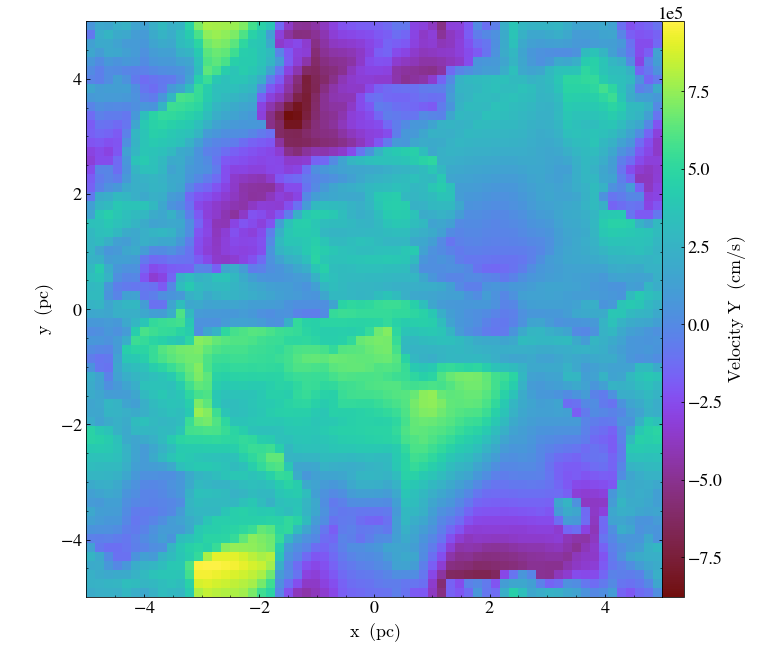
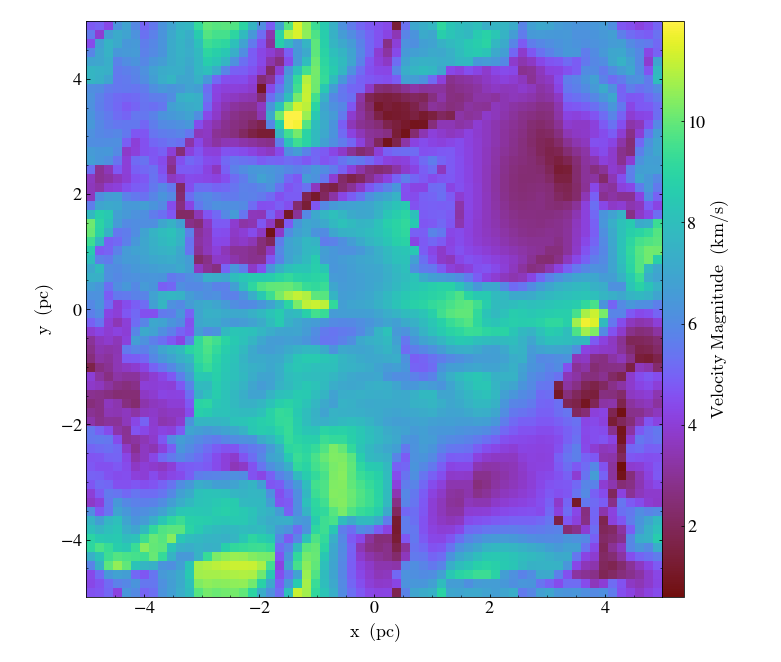
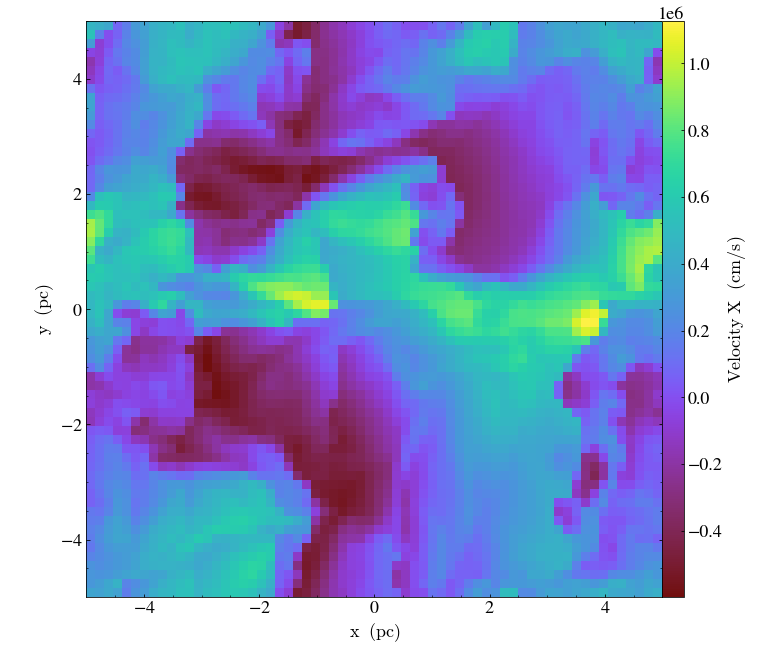
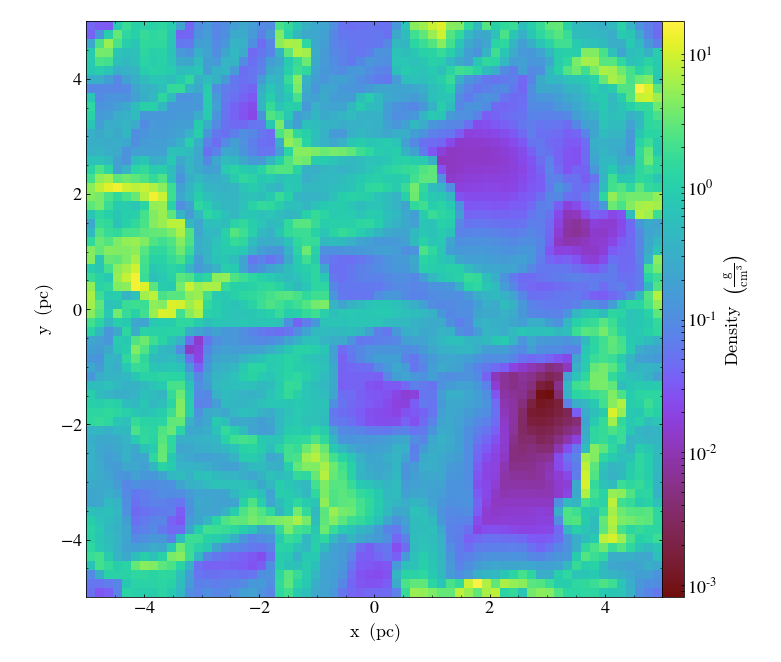

In [51]:
slc.set_log("velocity_x", False)
slc.set_log("velocity_y", False)
slc.set_log("velocity_magnitude", False)
slc.set_unit("velocity_magnitude", "km/s")
slc.show()

In [69]:
dd = ds.all_data()
vmin, vmax = dd.quantities.extrema("velocity_x").in_units("km/s").value
# consider lineofsight in x direction
L = [1,0,0]
cube = PPVCube(ds, L, "density", (vmin,vmax,64,"km/s"), dims=64, method="sum")

Generating cube.: 100%|██████████| 64/64 [00:04<00:00, 15.57it/s]


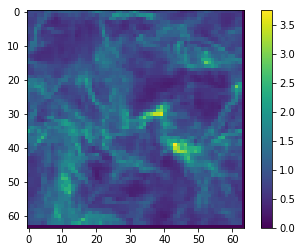

In [68]:
plt.imshow( cube.data.sum(axis=2)  )
plt.colorbar()

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
       52, 55, 58, 61])

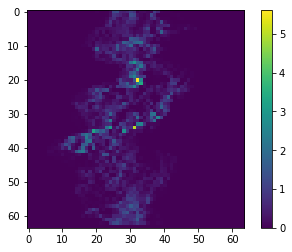

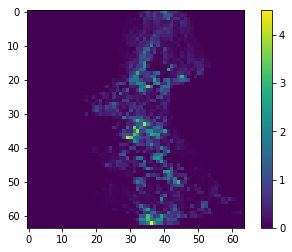

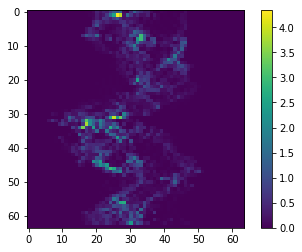

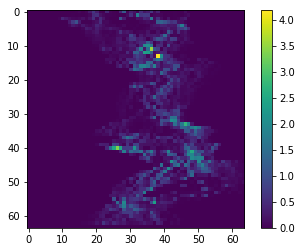

In [80]:
for i in np.arange(1,64,16):
    plt.imshow( cube.data[:,i,]*10.0)
    plt.colorbar()
    plt.show()

In [72]:
import h5py
f = h5py.File("E9_ppvx_cube64.h5", "w") 
f.create_dataset("ppv", data= cube.data)
f.close()